In [1]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

includet("Particle.jl")
using .ParticleFilter

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots
using StatsPlots
using CSV
using DataFrames


## Model & Priors

In [2]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)
# cycle_order
cycle_order = 1

# Create the support matrix
support = [
    0.0 1.0;  # ρ
    0.0 3.0;  # λ_c
    0.0 Inf;  # σ²_ε, y
    0.0 Inf;  # σ²_ξ, y
    0.0 Inf  # σ²_κ, y
]

# Create the prior distributions
prior_distributions = (
    "uniform",  # ρ
    "uniform",  # λ_c
    "uniform",  # σ²_ε, y
    "uniform",  # σ²_ξ, y 
    "uniform",  # σ²_κ, y
)

# Create the prior hyperparameters matrix
prior_hyperparameters = [
    0.0 1.0;  # ρ
    0.0 3.0;  # λ_c
    0.0 1e6;  # σ²_ε, y
    0.0 1e6;  # σ²_ξ, y
    0.0 1e6  # σ²_κ, y
]

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)


#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    # "ψ_{2,t}^y", 
    # "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]



4-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

## Data

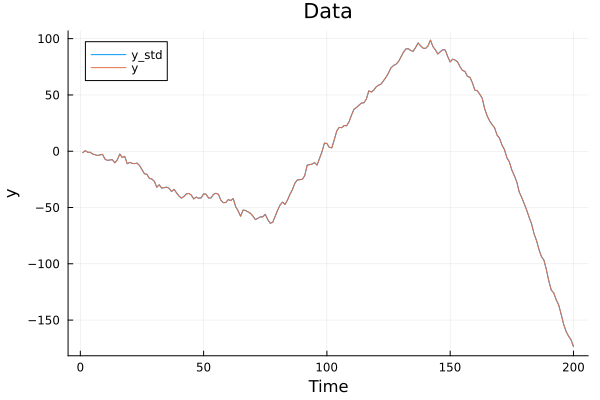

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [3]:
simulate = true



if simulate
    # True parameters
    # ρ = 0.5
    # λ_c = 0.2
    # σ²_ε_y = 4*10e-5
    # σ²_ξ_y = 4*10e-6
    # σ²_κ_y = 6*10e-5
    ρ = 0.9
    λ_c = π/3
    σ²_ε_y = 1.0
    σ²_ξ_y = 0.3
    σ²_κ_y = 0.5

    θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]

    Random.seed!(123)
    n_obs = 200
    y, α = simulate_data(θ_true, cycle_order, n_obs)
    # y_std, σʸ = standardize_data(y)
    y_std = y
    σʸ = 1.0

else
    # Load data
    data = CSV.read("data.csv", DataFrame)
    # Extract y 
    y = data.y
    # make y a matrix
    y = Matrix(y')
    # log transform y
    y = log.(y)
    println(size(y))
    y_std, σʸ = standardize_data(y)
    n_obs = length(y)
end


# plot data
plot(y_std[1,:], label="y_std", title="Standardized data", xlabel="Time", ylabel="y", legend=:topleft)
plot!(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
display(plot!())

# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
P0 = 1*Matrix{Float64}(I, length(α_elements), length(α_elements))

In [4]:
println(θ_true)

[0.9, 1.0471975511965976, 1.0, 0.3, 0.5]


In [5]:
# log_L_particle, states_particle = particle_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, N_particles = 10000)
# Log_L_kalman, states_kalman, _ = diffuse_kalman_filter(y_std, θ_true, α0, P0, cycle_order, σʸ, true, false)

# println("Log likelihood particle filter: ", log_L_particle)
# println("Log likelihood kalman filter: ", Log_L_kalman)

# println(size(states_particle))
# println(size(states_kalman))	

# # plot states
# for i in 1:length(α_elements)
#     plot(states_particle[i,:], label="particle", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
#     plot!(states_kalman[i,:], label="kalman", title=α_elements[i], xlabel="Time", ylabel=α_elements[i], legend=:topleft)
#     display(plot!())
# end

In [6]:
# initial_Γ = zeros(n_params)

# proposal_cov = 0.01*Matrix{Float64}(I, n_params, n_params)
# a1 = α0
# P1 = P0
# n_iterations = 1000
# σy = σʸ

# θ_chain, Γ_chain, log_posts, accept_rte = PMCMC_estimation(y,initial_Γ , n_iterations, cycle_order, σy, a1, P1, proposal_cov, prior_info; N_particles=1000)



In [7]:
# println(accept_rte)
# println(size(θ_chain))

# # plot trace plots with true value Line
# for i in 1:n_params
#     plot(θ_chain[:,i], label="θ_$i", title="Trace plot", xlabel="Iteration", ylabel="θ_$i", legend=:topleft)
#     hline!([θ_true[i]], label="True value", color="red")
#     display(plot!())
# end

## MCMC

In [8]:
θ_0 = [0.2, 0.3, 0.2, 0.1, 0.2]

θ_chain, θ_chain_init, α_draws = MCMC_estimation(y_std, prior_info, α0, P0, cycle_order, σʸ;
filter_type = "particle",
iter_init = 1000, 
 burn_init = 500,
 iter_rec = 1000,
burn_rec = 500,
θ_init = θ_0,
ω = 0.01)

Initialization Phase   5%|██                             |  ETA: 0:09:05

0.0122140275816017
0.5


Initialization Phase  10%|████                           |  ETA: 0:08:34

0.013498588075760034
0.4


Initialization Phase  15%|█████                          |  ETA: 0:07:59

0.011502737988572275
0.14


Initialization Phase  20%|███████                        |  ETA: 0:07:46

0.01020201340026756
0.18


Initialization Phase  25%|████████                       |  ETA: 0:07:18

0.00869358235398806
0.14


Initialization Phase  30%|██████████                     |  ETA: 0:06:56

0.00740818220681718
0.14


Initialization Phase  35%|███████████                    |  ETA: 0:06:27

0.0068386140921235595
0.22


Initialization Phase  40%|█████████████                  |  ETA: 0:06:03

0.005272924240430486
0.04


Initialization Phase  45%|██████████████                 |  ETA: 0:05:33

0.004065696597405992
0.04


Initialization Phase  50%|████████████████               |  ETA: 0:05:06

0.003134861808826053
0.04


Initialization Phase  55%|██████████████████             |  ETA: 0:04:37

0.002322362747297588
0.0


Initialization Phase  60%|███████████████████            |  ETA: 0:04:09

0.0017204486382305052
0.0


Initialization Phase  65%|█████████████████████          |  ETA: 0:03:40

0.0013002871087842592
0.02


Initialization Phase  70%|██████████████████████         |  ETA: 0:03:12

0.0010435048475476501
0.08


Initialization Phase  75%|████████████████████████       |  ETA: 0:02:42

0.0007730474044329974
0.0


Initialization Phase  80%|█████████████████████████      |  ETA: 0:02:11

0.0005726876026546735
0.0


Initialization Phase  85%|███████████████████████████    |  ETA: 0:01:38

0.0004242574108051138
0.0


Initialization Phase  90%|████████████████████████████   |  ETA: 0:01:05

0.00031429762018367704
0.0


Initialization Phase  95%|██████████████████████████████ |  ETA: 0:00:33

0.00023283740374897
0.0


Initialization Phase 100%|███████████████████████████████| Time: 0:10:55


0.0001724901911534627
0.0
Initialization Acceptance Rate: 9.700000000000001%


Recursion Phase 100%|████████████████████████████████████| Time: 0:15:53


Recursion Acceptance Rate: 0.8999999999999999%


([0.877256354660354 1.0655747563517748 … 0.1350690003140368 0.5754426919819801; 0.877256354660354 1.0655747563517748 … 0.1350690003140368 0.5754426919819801; … ; 0.8772565506277716 1.06556219352483 … 0.135069364440772 0.575462604754386; 0.8772565506277716 1.06556219352483 … 0.135069364440772 0.575462604754386], [0.549833997312478 1.7233275504349768 … 1.1051709180756477 1.2214027581601699; 0.5613748323788729 1.5692190673392945 … 1.2765310209766898 1.1791796860538952; … ; 0.8771014070173144 1.0658664210025048 … 0.13489048140451662 0.5742645871577087; 0.8771014070173144 1.0658664210025048 … 0.13489048140451662 0.5742645871577087], [-2.618387049384139 -1.5517985533219931 0.214178761065478 -0.4472090214325294; -0.9464298872295824 -0.042853435199943654 -0.8247785573187241 -1.0837915595937075; … ; -1.1860055066176327 2.192655215299476 -1.207911521113438 -0.2126235195437399; -1.5622194713929813 0.7212885789929812 0.8090444854557005 -0.2897725268605135;;; -1.292795800230263 0.12314998314253073 

Initial chain shape: (1000, 5)


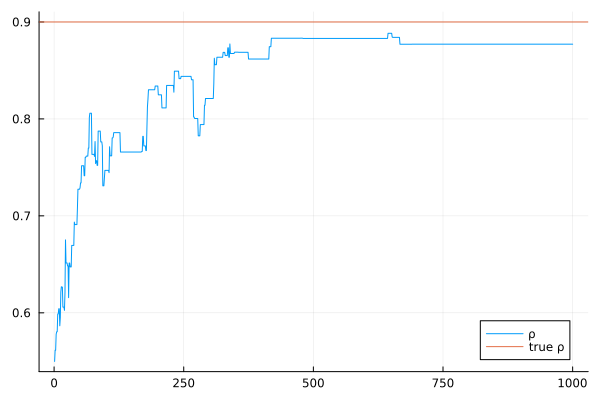

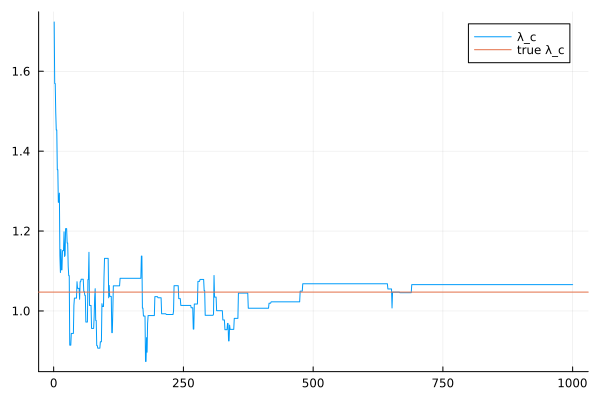

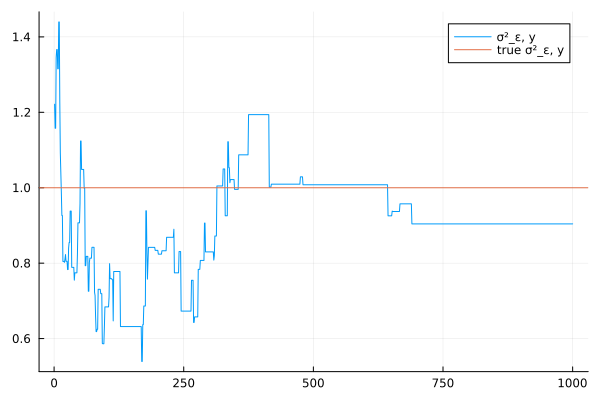

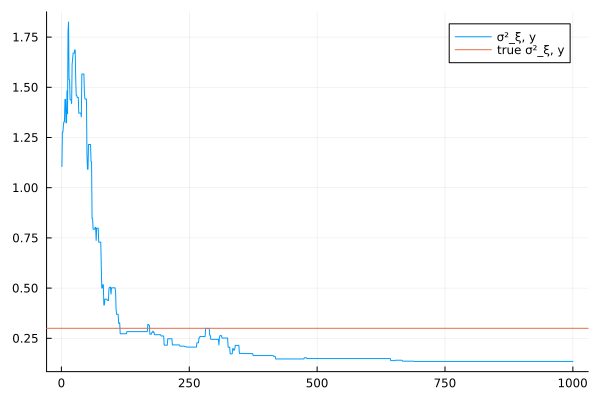

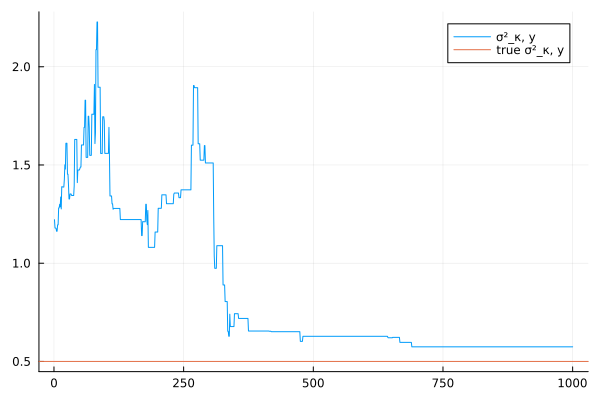

In [9]:
println("Initial chain shape: ", size(θ_chain_init))
#Print trace plot and add true value
for i in 1:size(θ_chain_init, 2)
    plot(θ_chain_init[:,i], label="$(θ_elements[i])")
    if simulate
        hline!([θ_true[i]], label="true $(θ_elements[i])")
    end
    display(plot!())
end

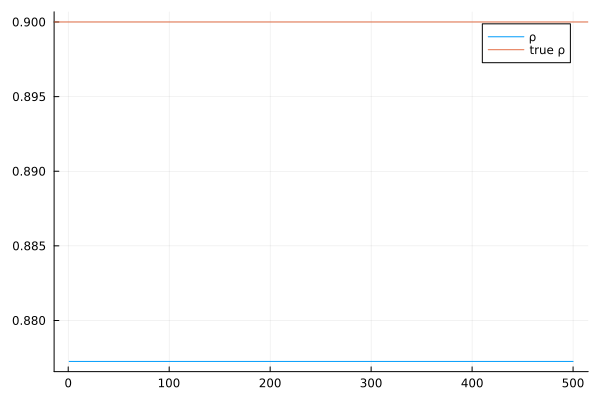

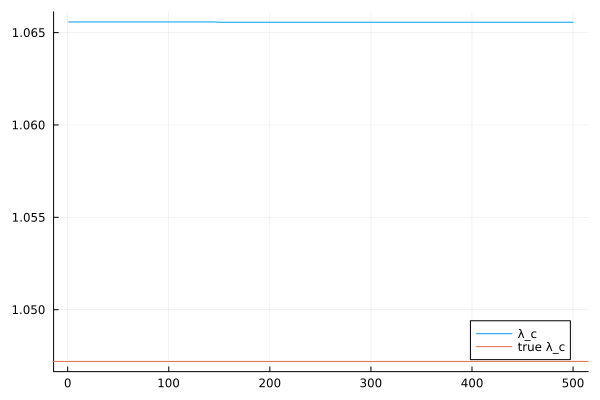

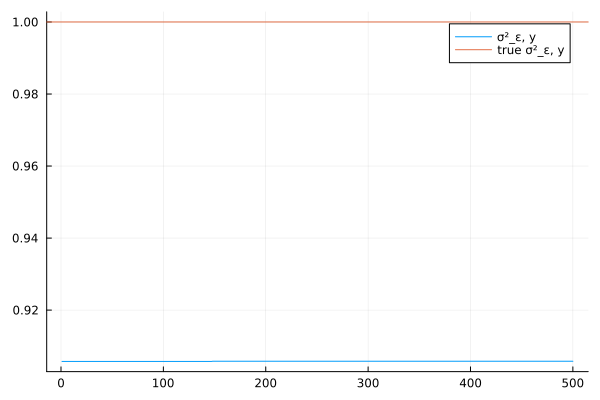

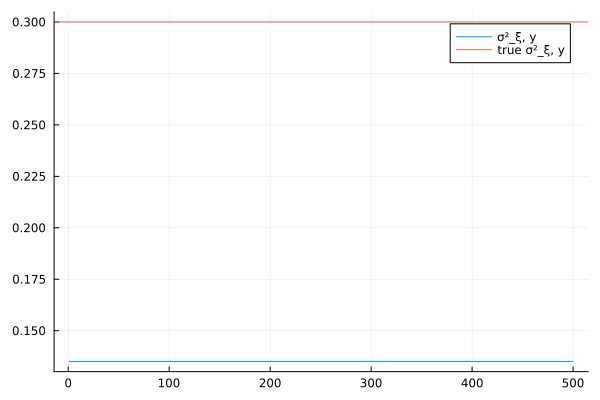

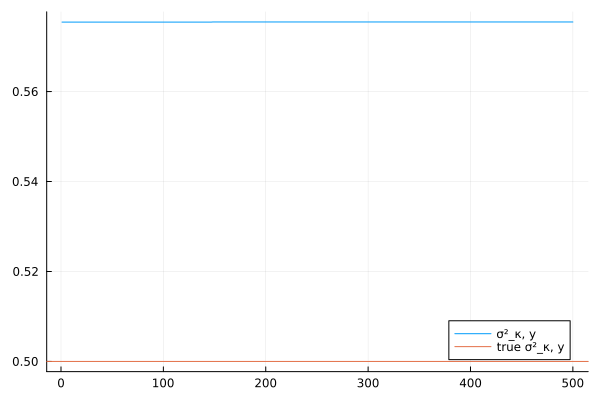

Rec chain shape: (500, 5)


In [10]:
println("Rec chain shape: ", size(θ_chain))

#Print trace plot and add true value
for i in 1:size(θ_chain, 2)
    plot(θ_chain[:,i], label="$(θ_elements[i])")
    if simulate
        hline!([θ_true[i]], label="true $(θ_elements[i])")
    end
    display(plot!())
end



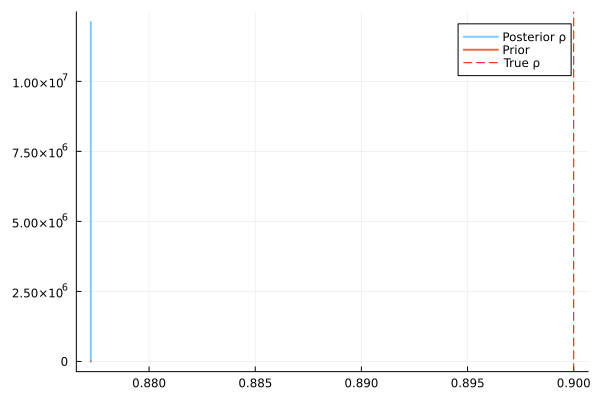

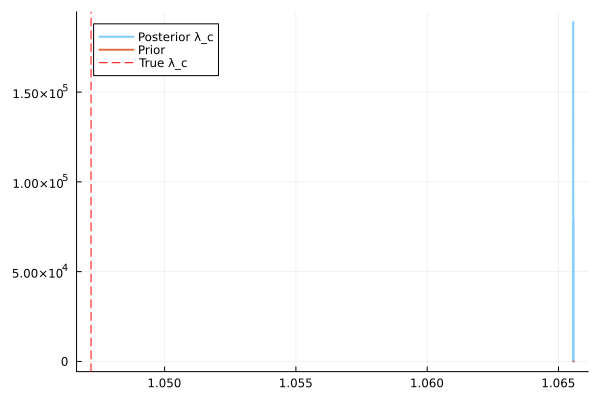

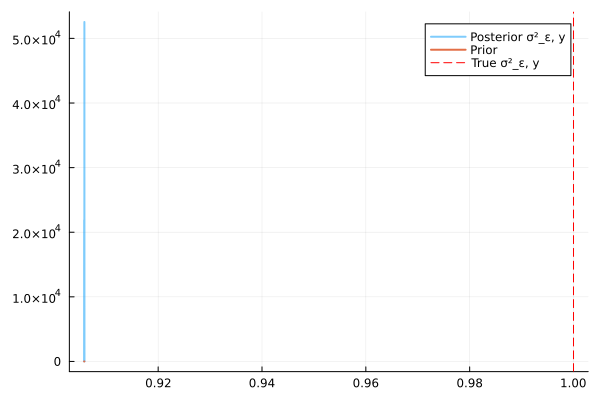

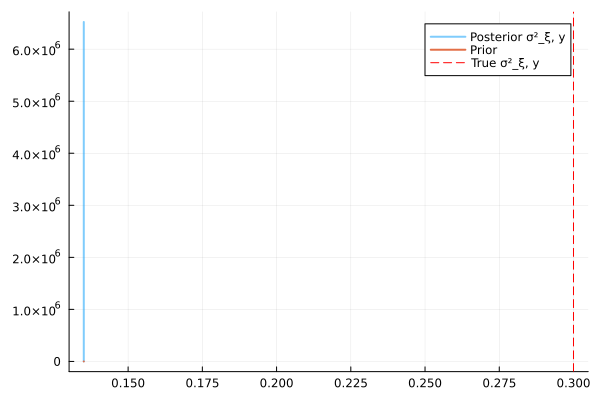

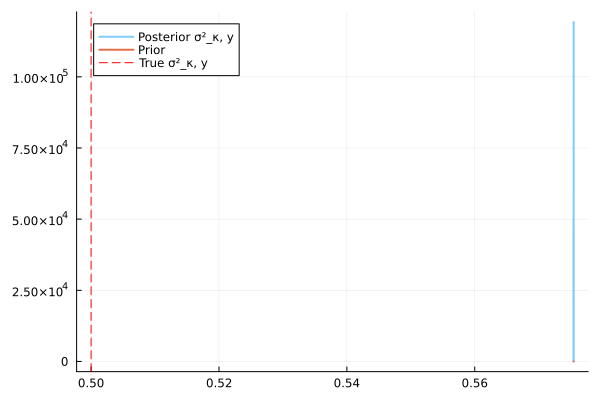

In [11]:

# Iterate through each parameter's chain
for i in 1:size(θ_chain, 2)
    # Plot kernel density estimate of the posterior
    density(θ_chain[:,i], label="Posterior $(θ_elements[i])", alpha=0.5, linewidth=2)

    # Prior distribution
    if prior_distributions[i] == "uniform"
        prior = Uniform(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "beta"
        prior = Beta(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "normal"
        prior = Normal(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    elseif prior_distributions[i] == "inverse gamma"
        prior = InverseGamma(prior_hyperparameters[i,1], prior_hyperparameters[i,2])
    end
    x_vals = range(minimum(θ_chain[:,i]), maximum(θ_chain[:,i]), length=100)
    plot!(x_vals, pdf.(prior, x_vals), label="Prior", linewidth=2)

    # True value
    if simulate
        vline!([θ_true[i]], label="True $(θ_elements[i])", linestyle=:dash, color=:red)
    end

    # Display the plot
    display(plot!())
end


Mean of α_draws: (1, 4, 200)


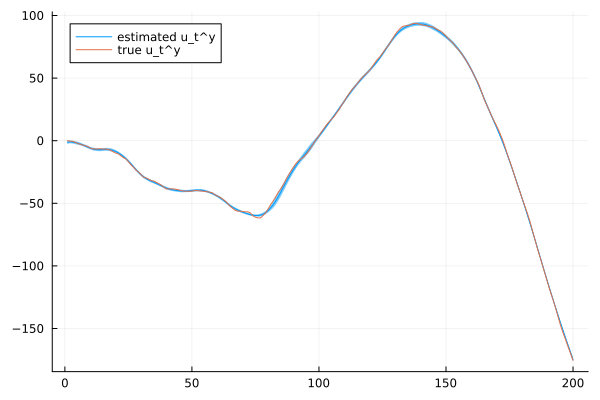

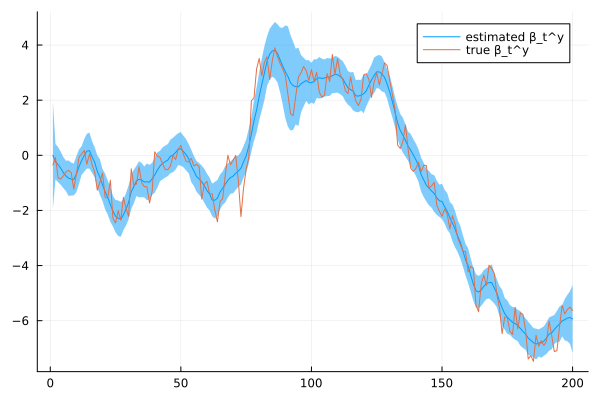

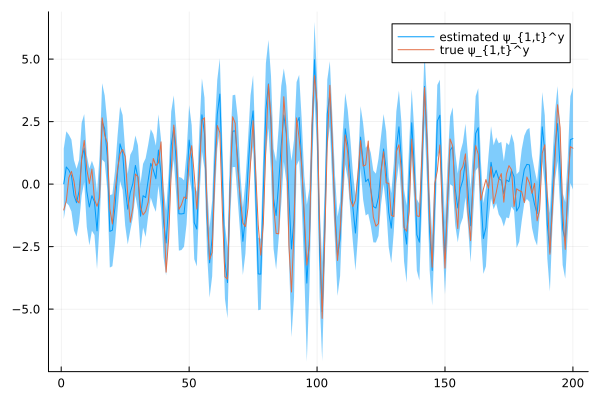

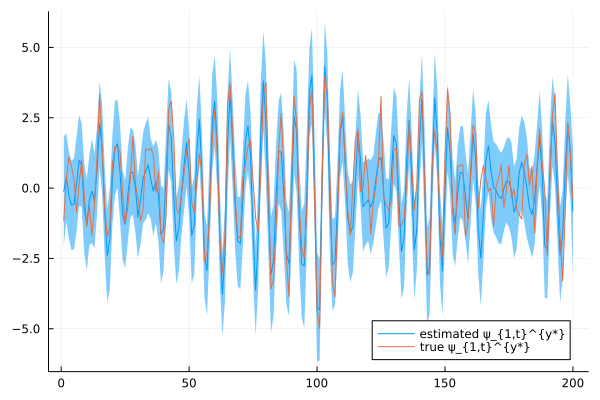

In [12]:
# Compute the mean over iterations (dimension 1)
α_mean = mean(α_draws, dims=1)
println("Mean of α_draws: ", size(α_mean))

# Compute the 2.5% and 97.5% quantiles 
α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)



# Plot true states, mean of states, and confidence intervals of states
for i in 1:size(α_mean, 2)
    plot(α_mean[1, i, :], ribbon=(α_ci[2, i, :] .- α_mean[1, i, :]), label="estimated $(α_elements[i])")
    if simulate
        plot!(α[i, :], label="true $(α_elements[i])")
    end
    display(plot!())
end


## MLE

In [13]:
# using Optim


# lower_bounds = [0.0, 0.0, 1e-12, 1e-12, 1e-12]
# upper_bounds = [1.0, 3.0, 3.0, 3.0, 3.0]
# θ_init = [0.5, 0.1, 4*10e-5, 4*10e-6, 6*10e-5]

# objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order, σʸ)
# res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
# θ_est = Optim.minimizer(res)

# # Print the results:
# println("MLE Results (with bounded optimization):")
# for (i, param_name) in enumerate(θ_elements)
#     println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
# end
# println("Final negative log-likelihood: ", Optim.minimum(res))


In [14]:
# # estimate states
# LogL_diff, α_diff, P_diff = diffuse_kalman_filter(y, θ_est, α0, P0, cycle_order, σʸ,  true, false)

# #plot estimated states and true states
# for i in 1:size(α,2)
#     plot(α[:,i], label="true $(α_elements[i])")
#     plot!(α_diff[:,i], label="estimated $(α_elements[i])")
#     display(plot!())
# end

